# CCA for different underlying latent structures





In [153]:
import numpy as np
from scipy.linalg import sqrtm

from statsmodels.multivariate.cancorr import CanCorr as smCCA
from sklearn.cross_decomposition import CCA as skCCA

import matplotlib.pyplot as plt
from seaborn import heatmap

## Plotting function

In [154]:
def plot_cca(a, b, U, V, s, X, Y):
    # plotting
    N = np.min([X.shape[1], Y.shape[1]])
    plt.figure()
    heatmap(a, square=True, center=0)
    plt.title("Canonical vector - x")
    plt.figure()
    heatmap(b, square=True, center=0)
    plt.title("Canonical vector - y")

    plt.figure(figsize=(9, 6))
    for i in range(N):

        plt.subplot(221 + i)
        plt.scatter(np.array(X_score[:, i]).reshape(100), 
                    np.array(Y_score[:, i]).reshape(100), 
                    marker="o", c="b", s=25)
        plt.xlabel("Canonical variate of X")
        plt.ylabel("Canonical variate of Y")
        plt.title('Mode %i (corr = %.2f)' %(i + 1, s[i]))
        plt.xticks(())
        plt.yticks(())

## Function to simulate data given a latent structure

In [155]:
def simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent):
    
    """
    Parameters
    ----------
    n_obs : int
        Number of observations (this is common to X and Y)
    x_nvars : int
        Number of (observed) variables in X dataset
    y_nvars : int
        Number of (observed) variables in Y dataset
    lx_array : array 
        Specifying latent factor for each of the variables in X
    ly_array : array 
        Specifying latent factor for of the variables in Y
    n_latent : int
        Number of latent variables hidden in both X and Y datasets
    
    Returns
    -------
    X : array
        Dataset X of size (n_obs, x_nvars) containing n_latent hidden latent variables
    Y : array
        Dataset Y of size (n_obs, y_nvars) containing n_latent hidden latent variables
    """

    l_array = np.ones(shape=(n_obs, n_latent))
    lX = np.ones(shape=(n_obs, x_nvars))
    lY = np.ones(shape=(n_obs, y_nvars))

    for i in range(n_latent):
        l_array[:,i] = np.random.normal(size=n_obs)

    for i in range(x_nvars):
        lx = lx_array[i] 
        lX[:,i] = l_array[:,lx]

    for i in range(y_nvars):
        ly = ly_array[i]
        lY[:,i] = l_array[:,ly]

    X = lX + np.random.normal(size=(n_obs,x_nvars))
    Y = lY + np.random.normal(size=(n_obs,y_nvars))
    
    return X, Y  

## Function to compute cca (and call plot_cca)

In [156]:
def compute_cca(X, Y):

    Cx, Cy = np.corrcoef(X.T), np.corrcoef(Y.T)
    Cxy =  np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:]
    Cyx =  Cxy.T
    
    sqrt_x, sqrt_y = np.matrix(sqrtm(Cx)), np.matrix(sqrtm(Cy))
    isqrt_x, isqrt_y = sqrt_x.I, sqrt_y.I
    
    W = isqrt_x * Cxy * isqrt_y
    u, s, v = np.linalg.svd(W)
    
    N = np.min([X.shape[1], Y.shape[1]])
    a = np.dot(u, isqrt_x.T[:, :N]) / np.std(X) # scaling because we didn't standardise the input
    b = np.dot(v, isqrt_y).T / np.std(Y)
    
    X_score, Y_score = X.dot(a), Y.dot(b)

    plot_cca(a, b, X_score, Y_score, s, X, Y)

## Define different models and compare plots

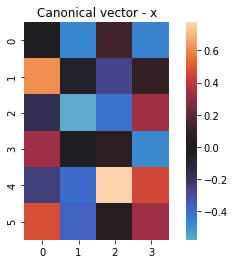

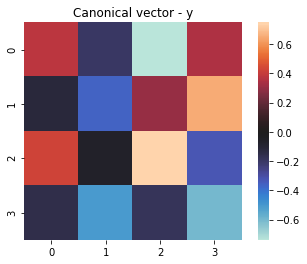

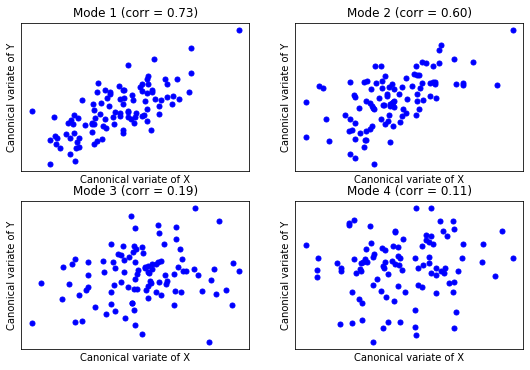

In [161]:
import numpy as np
np.random.seed(42)

# model 1
n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [0, 1, 0, 1, 0, 1]
ly_array = [1, 0, 1, 0]

X0, Y0 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
    
compute_cca(X0, Y0)


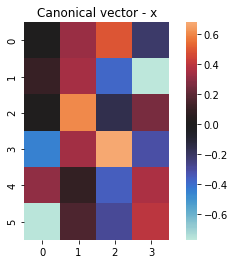

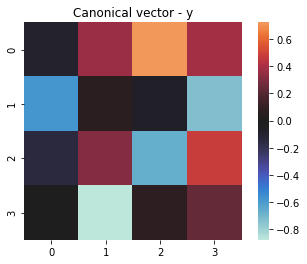

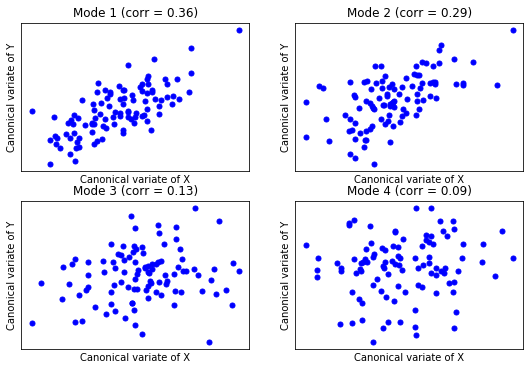

In [162]:
# model 2
n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [0, 0, 0, 0, 0, 0]
ly_array = [1, 1, 1, 1] 

X1, Y1 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)

compute_cca(X1, Y1)

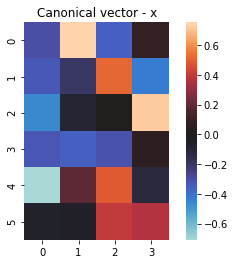

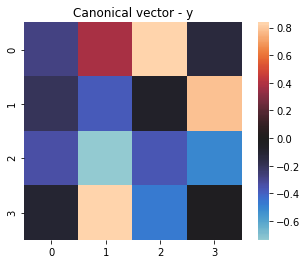

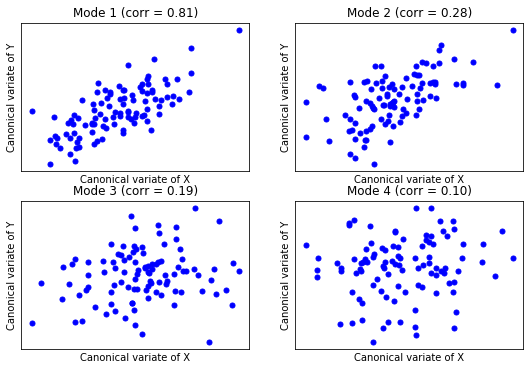

In [164]:
# model 3
n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [1, 1, 1, 1, 1, 0]
ly_array = [1, 1, 1, 1] 

X2, Y2 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
compute_cca(X2, Y2)